In [11]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import re
import os
from datetime import datetime, timedelta
os.getcwd()
df = pd.DataFrame()

In [12]:
df = pd.read_csv('./dws_dsc_activity_hourly_detail_di.csv', nrows = 15555)
re1 = re.compile(r'(?<=\.).+')
df.columns = [re1.findall(i)[0] for i in list(df.columns.to_numpy())]
df = df.dropna(subset=['activity_start_time'])


In [13]:
df['activity_end_time'] = pd.to_datetime(df['activity_end_time'])
df['activity_start_time'] = pd.to_datetime(df['activity_start_time'].fillna(0))
df['create_time'] = pd.to_datetime(df['create_time'])

In [14]:
"""
d单个activity的耗费时间.
"""
df['time_gap_inner'] = df['activity_end_time']-df['activity_start_time']
df['time_gap_inner'] = df['time_gap_inner'].fillna(
    timedelta(0)
    ).apply(timedelta.total_seconds)
df['time_gap_inner'] = [0 if i < 0 else i for i in df['time_gap_inner']]

"""
前一个activity到后一个activity相差的时间\.
"""
df = df.sort_values('activity_start_time')
df['time_gap_outer'] = df\
    .groupby(['user_id','inc_day'], dropna = False)['activity_start_time'].transform('diff')
df['time_gap_outer'] = df['time_gap_outer'].fillna(timedelta(0)).apply(timedelta.total_seconds)
df['time_gap_outer'] = [0 if i< 0 else i for i in df['time_gap_outer']]

"""
time gap of the day. 总计活跃时间
"""
mid1 = df.groupby(['inc_day', 'user_id']).agg(
    a = ('activity_start_time','min'), 
    b  = ('activity_start_time', 'max'))\
        [['a','b']].diff(axis = 1)['b'].apply(timedelta.total_seconds).reset_index()
mid1.columns = ['inc_day','user_id','time_gap_today']
df = df.merge(mid1, on = ['inc_day', 'user_id'], how = 'left')


In [15]:
def get_hour():
    list = ['activity_start_time', 'activity_end_time','create_time']
    
    for i in list: 
        listnew = i + '_hour'
        df[listnew] = df[i].dt.round('min').astype(str).str.slice(11,)
    return df
df = get_hour() 

In [16]:
df[df['wms_warehouse_id'] == 'H15'][['activity_start_time', 'activity_end_time',  'create_time']]

,activity_start_time,activity_end_time,create_time
4733,2021-09-26 03:30:12,2021-09-26 03:33:09,2021-09-26 03:33:09
4756,2021-09-26 03:33:09,2021-09-26 03:33:09,2021-09-26 03:33:09
4757,2021-09-26 03:33:09,2021-09-26 03:33:09,2021-09-26 03:33:09
4758,2021-09-26 03:33:09,2021-09-26 03:33:09,2021-09-26 03:33:09
4759,2021-09-26 03:33:09,2021-09-26 03:33:09,2021-09-26 03:33:09
...,...,...,...
4825,2021-09-26 03:33:09,2021-09-26 03:33:09,2021-09-26 03:33:09
4826,2021-09-26 03:33:09,2021-09-26 03:33:09,2021-09-26 03:33:09
4827,2021-09-26 03:33:09,2021-09-26 03:33:09,2021-09-26 03:33:09
4828,2021-09-26 03:33:09,2021-09-26 03:33:09,2021-09-26 03:33:09


In [17]:
df[['ou_code', 'ou_name', 'wms_warehouse_id', 'user_id', 'activity_type', 'activity_sub_type',
       'activity_start_time', 'activity_end_time',  'create_time',
       'activity_id', 'inc_day',
       'time_gap_inner','time_gap_outer','time_gap_today',
       'activity_start_time_hour', 'activity_end_time_hour', 'create_time_hour']]

,ou_code,ou_name,wms_warehouse_id,user_id,activity_type,activity_sub_type,activity_start_time,activity_end_time,create_time,activity_id,inc_day,time_gap_inner,time_gap_outer,time_gap_today,activity_start_time_hour,activity_end_time_hour,create_time_hour
0,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,Pack Cubed Directed,2021-09-26 00:00:33,2021-09-26 00:00:33,2021-09-26 00:00:33,233116934,20210926,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
1,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,Pack Cubed Directed,2021-09-26 00:00:34,2021-09-26 00:00:34,2021-09-26 00:00:34,233116940,20210926,0.0,1.0,29106.0,00:01:00,00:01:00,00:01:00
2,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,Pack Cubed Directed,2021-09-26 00:00:34,2021-09-26 00:00:34,2021-09-26 00:00:34,233116938,20210926,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
3,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,Pack Cubed Directed,2021-09-26 00:00:34,2021-09-26 00:00:34,2021-09-26 00:00:34,233116943,20210926,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
4,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,Pack Cubed Directed,2021-09-26 00:00:34,2021-09-26 00:00:34,2021-09-26 00:00:34,233116946,20210926,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15534,CN-175,SIEMENS SZV XXX WHS,C21,SIERF06,Replenish,SLC Pull Pallet Rep,2021-09-26 08:23:00,2021-09-26 08:23:00,2021-09-26 08:23:00,233146463,20210926,0.0,23.0,1865.0,08:23:00,08:23:00,08:23:00
15535,CN-175,SIEMENS SZV XXX WHS,C21,SIERF06,Replenish,SLC Pull Pallet Rep,2021-09-26 08:23:00,2021-09-26 08:23:01,2021-09-26 08:23:01,233146464,20210926,1.0,0.0,1865.0,08:23:00,08:23:00,08:23:00
15536,CN-175,SIEMENS SZV XXX WHS,C21,SIERF06,Replenish,SLC Pull Pallet Rep,2021-09-26 08:23:01,2021-09-26 08:23:01,2021-09-26 08:23:01,233146466,20210926,0.0,1.0,1865.0,08:23:00,08:23:00,08:23:00
15537,CN-175,SIEMENS SZV XXX WHS,C21,SIERF06,Replenish,SLC Pull Pallet Rep,2021-09-26 08:23:01,2021-09-26 08:23:01,2021-09-26 08:23:01,233146465,20210926,0.0,0.0,1865.0,08:23:00,08:23:00,08:23:00


In [18]:
df[['ou_code', 'ou_name', 'bg_code', 'bg_name_cn', 'customer_id',
       'customer_name', 'hour',
       'wms_warehouse_id', 'user_id', 'activity_type', 'activity_sub_type',
       'activity_start_time', 'activity_end_time', 'lpn', 'sku_code',
       'order_id', 'from_location', 'to_location', 'qty', 'create_time',
       'activity_id', 'inc_day',
       'time_gap_inner','time_gap_outer','time_gap_today',
       'activity_start_time_hour', 'activity_end_time_hour', 'create_time_hour']].\
              to_csv('./activi_for.csv', index=None, encoding='utf_8_sig')

In [19]:
# df.groupby(['inc_day', 'user_id']).agg(
#     a = ('activity_start_time','min'), 
#     b  = ('activity_start_time', 'max'))[['a','b']].diff(axis = 1)['b']\
# .apply(timedelta.total_seconds).reset_index()
# df[df['user_id'] == 'DSCSZXP0325'][[
# 'activity_start_time','time_gap_inner','time_gap_outer','time_gap_today'
# ]].sort_values('activity_start_time')

In [20]:
plt_data = df[['ou_code', 'ou_name', 'bg_code', 'bg_name_cn', 'customer_id',
       'customer_name', 'hour',
       'wms_warehouse_id', 'user_id', 'activity_type', 'activity_sub_type',
       'activity_start_time', 'activity_end_time', 'lpn', 'sku_code',
       'order_id', 'from_location', 'to_location', 'qty', 'create_time',
       'activity_id', 'inc_day',
       'time_gap_inner','time_gap_outer','time_gap_today',
       'activity_start_time_hour', 'activity_end_time_hour', 'create_time_hour']]

In [21]:
import seaborn as sns

C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='activity_start_time', ylabel='time_gap_inner'>

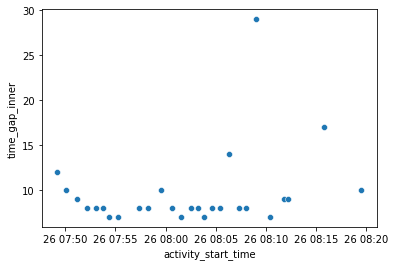

In [22]:
sns.scatterplot('activity_start_time', 'time_gap_inner', \
    data= plt_data[plt_data['user_id'] == 'SIERF54'] )